In [32]:
from cmath import polar

import duckdb
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.functions import trim, when
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType, DateType, LongType, \
    DoubleType, TimestampType, BooleanType
import polars as pl
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import os


In [4]:
os.environ["PYSPARK_PYTHON"] = r"D:/DataEngineer/Learn-yourself/stock-data-pipeline/.venv/Scripts/python.exe"

spark = SparkSession.builder.appName("Data Analysis").getOrCreate()


**1. Quan sát và phân tích Dim Companies**

In [5]:
conn = duckdb.connect("../database/config_dwh/mydb.duckdb")

query = 'SELECT * FROM dim_companies'
temp = conn.execute(query).fetchdf()

conn.close()

In [6]:
df_companies = spark.createDataFrame(temp)
df_companies.printSchema()
df_companies.show()

root
 |-- id: long (nullable = true)
 |-- name: string (nullable = true)
 |-- ticker: string (nullable = true)
 |-- is_delisted: boolean (nullable = true)
 |-- category: string (nullable = true)
 |-- currency: string (nullable = true)
 |-- location: string (nullable = true)
 |-- exchange: string (nullable = true)
 |-- region: string (nullable = true)
 |-- industry: string (nullable = true)
 |-- sector: string (nullable = true)
 |-- sic_industry: string (nullable = true)
 |-- sic_sector: string (nullable = true)
 |-- updated_time: timestamp (nullable = true)

+----+--------------------+------+-----------+--------------------+--------+--------------------+--------+-------------+--------------------+-----------------+--------------------+--------------------+--------------------+
|  id|                name|ticker|is_delisted|            category|currency|            location|exchange|       region|            industry|           sector|        sic_industry|          sic_sector|        upd

Lọc ra các bản ghi công ty mới nhất theo updated_time

In [7]:
#Tạo window spec để phân nhóm theo ticker và sắp xếp theo updated_time giảm dần
windowSpec = Window.partitionBy("ticker").orderBy(F.desc("updated_time"))
#Sử dụng row_number để đánh số thứ tự trong mỗi nhóm
df_companies = df_companies.withColumn("row_num", F.row_number().over(windowSpec))
#Lọc ra các bản ghi mới nhất (row_num = 1)
df_companies = df_companies.filter(F.col("row_num") == 1).drop("row_num")
#Hiển thị kết quả
print("Số lượng công ty:", df_companies.count())
df_companies.show()

Số lượng công ty: 23670
+-----+--------------------+-------+-----------+--------------------+--------+-------------------+--------+-------------+--------------------+------------------+--------------------+--------------------+--------------------+
|   id|                name| ticker|is_delisted|            category|currency|           location|exchange|       region|            industry|            sector|        sic_industry|          sic_sector|        updated_time|
+-----+--------------------+-------+-----------+--------------------+--------+-------------------+--------+-------------+--------------------+------------------+--------------------+--------------------+--------------------+
|15848|          ALCOA CORP|     AA|      false|Domestic Common S...|     USD|Pennsylvania; U.S.A|    NYSE|United States|            Aluminum|   Basic Materials|Primary Productio...|       Manufacturing|2025-07-26 04:45:...|
|19606|ALTANA AKTIENGESE...|  AAAGY|       true|    ADR Common Stock|     US

Thống kê số lượng mã niêm yết theo từng sàn giao dịch

In [8]:
df_companies.groupBy("exchange").agg(F.count("*").alias("count")) \
    .withColumnRenamed("exchange", "Sàn giao dịch") \
    .withColumnRenamed("count", "Số lượng mã niêm yết") \
    .orderBy(F.desc("Số lượng mã niêm yết")) \
    .show()

+-------------+--------------------+
|Sàn giao dịch|Số lượng mã niêm yết|
+-------------+--------------------+
|       NASDAQ|               15255|
|         NYSE|                8415|
+-------------+--------------------+



Thống kê số lượng công ty theo từng quốc gia

In [10]:
df_companies.withColumn("country", F.element_at(F.split(F.col("location"), ";"), -1)) \
    .groupBy("country").agg(F.count("*").alias("count")) \
    .withColumnRenamed("country", "Quốc gia") \
    .withColumnRenamed("count", "Số lượng công ty") \
    .orderBy(F.desc("Số lượng công ty")) \
    .show()

+--------------+----------------+
|      Quốc gia|Số lượng công ty|
+--------------+----------------+
|         U.S.A|           19517|
|              |             654|
|         China|             594|
|        Canada|             553|
|United Kingdom|             281|
|        Israel|             237|
|Cayman Islands|             217|
|       Bermuda|             190|
|     Hong Kong|             143|
|     Singapore|             113|
|       Ireland|              83|
|        Brazil|              75|
|   Netherlands|              69|
|     Australia|              68|
|       Germany|              57|
|    Luxembourg|              55|
|         Japan|              54|
|        Greece|              51|
|   Switzerland|              48|
|        Taiwan|              45|
+--------------+----------------+
only showing top 20 rows



Thống kê số lượng công ty theo ngành công nghiệp:

In [14]:
df_companies.groupBy("sector").agg(F.count("*").alias("count")) \
    .filter(F.col("sector").isNotNull() & (trim(F.col("sector"))!="")) \
    .withColumnRenamed("sector", "Ngành công nghiệp") \
    .withColumnRenamed("count", "Số lượng công ty") \
    .orderBy(F.desc("Số lượng công ty")) \
    .show()

+--------------------+----------------+
|   Ngành công nghiệp|Số lượng công ty|
+--------------------+----------------+
|         Industrials|            3926|
|          Technology|            3504|
|          Healthcare|            3060|
|  Financial Services|            2980|
|   Consumer Cyclical|            1910|
|Communication Ser...|            1166|
|         Real Estate|            1020|
|     Basic Materials|             861|
|              Energy|             857|
|  Consumer Defensive|             771|
|           Utilities|             379|
+--------------------+----------------+



Thống kê số lượng công ty theo ngành công nghiệp SIC:

In [15]:
df_companies.groupBy("sic_sector").agg(F.count("*").alias("count")) \
    .filter(F.col("sic_sector").isNotNull() & (trim(F.col("sic_sector"))!="")) \
    .withColumnRenamed("sector", "Ngành công nghiệp SIC") \
    .withColumnRenamed("count", "Số lượng công ty") \
    .orderBy(F.desc("Số lượng công ty")) \
    .show()

+--------------------+----------------+
|          sic_sector|Số lượng công ty|
+--------------------+----------------+
|       Manufacturing|            6611|
|Finance Insurance...|            6294|
|            Services|            3939|
|Transportation Co...|            1747|
|        Retail Trade|             885|
|              Mining|             743|
|     Wholesale Trade|             432|
|        Construction|             177|
|Agriculture Fores...|              72|
+--------------------+----------------+



Đếm số lượng công ty đang hoạt động vs đã hủy niêm yết

In [18]:
df_companies \
    .withColumn(
        "Trạng thái niêm yết",
        when(F.col("is_delisted") == True, "Đã hủy niêm yết")
        .otherwise("Đang hoạt động")
    ) \
    .groupBy("Trạng thái niêm yết") \
    .agg(F.count("*").alias("Số lượng công ty")) \
    .orderBy(F.desc("Số lượng công ty")) \
    .show()

+-------------------+----------------+
|Trạng thái niêm yết|Số lượng công ty|
+-------------------+----------------+
|    Đã hủy niêm yết|           15818|
|     Đang hoạt động|            7852|
+-------------------+----------------+



**2. Quan sát và phân tích Fact_candles**

In [21]:
conn = duckdb.connect("../database/config_dwh/mydb.duckdb")

query = 'SELECT * FROM fact_candles'
temp = conn.execute(query).fetchdf()
print(temp)
conn.close()

          id  company_id   volume  volume_weighted      open   close  \
0          1        3282    30496           9.8046    9.9750    9.66   
1          2       18269    58132           7.1153    7.1900    7.12   
2          3        6143    41919          20.0695   19.9500   20.04   
3          4       20476   111650          66.2008   66.4000   66.09   
4          5        7741  1365308         119.4873  119.0300  119.07   
...      ...         ...      ...              ...       ...     ...   
52985  52986       21908   367163           1.0391    1.0500    1.02   
52986  52987       15231   357524         114.6659  115.3100  114.88   
52987  52988         559     1868          35.6776   35.7074   35.70   
52988  52989        8576   317538           4.1735    4.3300    4.13   
52989  52990        1886    63578           6.9999    6.9899    6.96   

           high       low     time_stamp  num_of_trades  is_otc  time_id  
0       10.0300    9.4079  1752177600000            337    <

In [26]:
#Chuyển đổi dữ liệu cho phù hợp
df_temp = pl.from_pandas(temp)
df_temp = df_temp.with_columns([
    pl.col("is_otc").fill_null(False).cast(pl.Boolean),
    pl.col("time_stamp").cast(pl.Int64).cast(pl.Datetime("ms"))
])

df_temp.head(5)

id,company_id,volume,volume_weighted,open,close,high,low,time_stamp,num_of_trades,is_otc,time_id
i32,i32,i32,f64,f64,f64,f64,f64,datetime[ms],i32,bool,i32
1,3282,30496,9.8046,9.975,9.66,10.03,9.4079,2025-07-10 20:00:00,337,false,1
2,18269,58132,7.1153,7.19,7.12,7.19,7.07,2025-07-10 20:00:00,255,false,1
3,6143,41919,20.0695,19.95,20.04,20.15,19.9,2025-07-10 20:00:00,206,false,1
4,20476,111650,66.2008,66.4,66.09,66.4,65.96,2025-07-10 20:00:00,685,false,1
5,7741,1365308,119.4873,119.03,119.07,120.91,118.31,2025-07-10 20:00:00,25673,false,1


In [34]:
candles_schema = StructType([
    StructField("id", IntegerType(), True),
    StructField("company_id", IntegerType(), True),
    StructField("volume", LongType(), True),
    StructField("volume_weighted",DoubleType(), True),
    StructField("open", DoubleType(), True),
    StructField("close", DoubleType(), True),
    StructField("high", DoubleType(), True),
    StructField("low", DoubleType(), True),
    StructField("time_stamp", TimestampType(), True),
    StructField("num_of_trades", IntegerType(), True),
    StructField("is_otc", BooleanType(), True),
    StructField("time_id", IntegerType(), True),
])

df_candles = spark.createDataFrame(df_temp.to_pandas(), schema=candles_schema)
df_candles.printSchema()
df_candles.show()


root
 |-- id: integer (nullable = true)
 |-- company_id: integer (nullable = true)
 |-- volume: long (nullable = true)
 |-- volume_weighted: double (nullable = true)
 |-- open: double (nullable = true)
 |-- close: double (nullable = true)
 |-- high: double (nullable = true)
 |-- low: double (nullable = true)
 |-- time_stamp: timestamp (nullable = true)
 |-- num_of_trades: integer (nullable = true)
 |-- is_otc: boolean (nullable = true)
 |-- time_id: integer (nullable = true)

+---+----------+-------+---------------+-------+------+-------+------+-------------------+-------------+------+-------+
| id|company_id| volume|volume_weighted|   open| close|   high|   low|         time_stamp|num_of_trades|is_otc|time_id|
+---+----------+-------+---------------+-------+------+-------+------+-------------------+-------------+------+-------+
|  1|      3282|  30496|         9.8046|  9.975|  9.66|  10.03|9.4079|2025-07-10 20:00:00|          337| false|      1|
|  2|     18269|  58132|         7.1153

Thống kê khối lượng cổ phiếu giao dịch trong ngày

+--------------+--------------------------------------------------+---------------------------+---------------+
|Ngày giao dịch|Tổng khối lượng cổ phiếu được giao dịch trong ngày|Tổng số giao dịch thực hiện|Số lượng mã OTC|
+--------------+--------------------------------------------------+---------------------------+---------------+
|    2025-07-18|                                       14868246120|                   94118278|            392|
|    2025-07-17|                                       16146259468|                   99023228|            422|
|    2025-07-16|                                       14706706182|                   95234589|            388|
|    2025-07-15|                                       13938503382|                   92813032|            409|
|    2025-07-14|                                       12989501605|                   88622077|            409|
|    2025-07-11|                                       13151819284|                   85369005|         

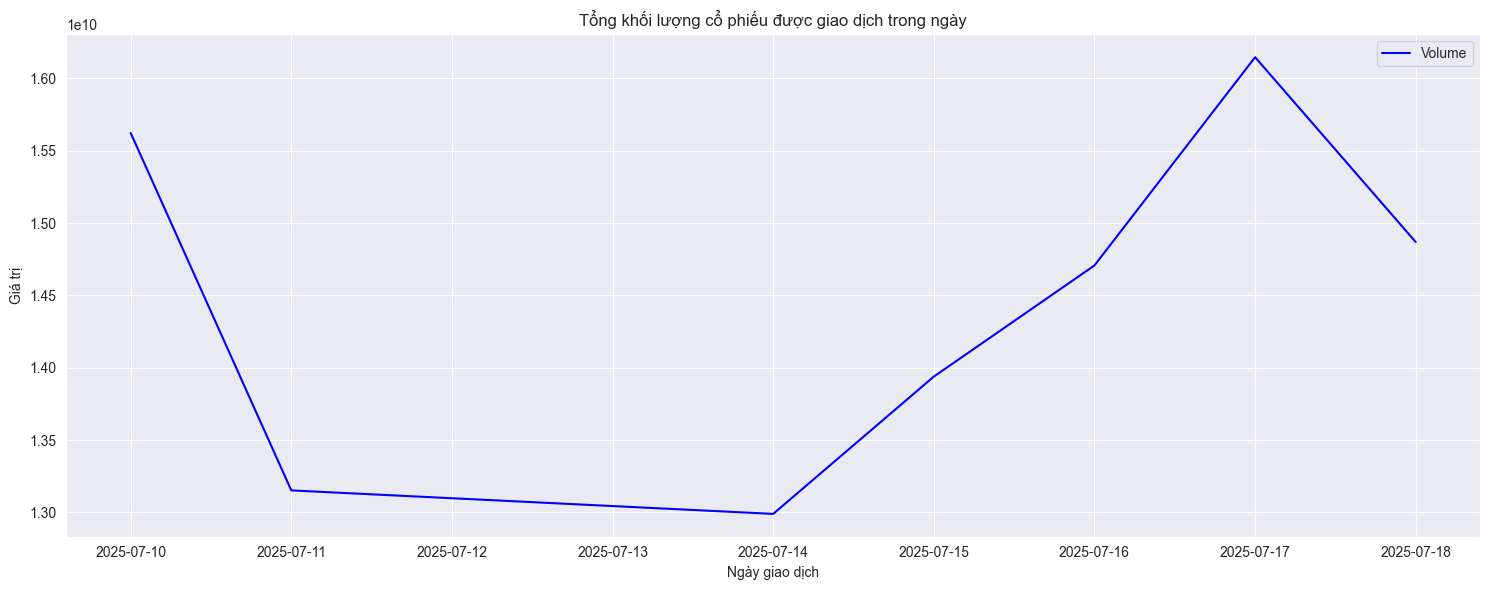

In [38]:
df_chart = df_candles.withColumn("time_stamp", F.to_date(F.col("time_stamp"))) \
    .groupBy("time_stamp") \
    .agg(F.sum("volume").alias("Tổng khối lượng cổ phiếu được giao dịch trong ngày"),
         F.sum("num_of_trades").alias("Tổng số giao dịch thực hiện"),
         F.sum(F.when(F.col("is_otc")==True, 1).otherwise(0)).alias("Số lượng mã OTC")) \
    .withColumnRenamed("time_stamp", "Ngày giao dịch") \
    .orderBy(F.desc("Ngày giao dịch")) \

df_chart.show()
df_pd = df_chart.toPandas()

plt.figure(figsize=(15,6))
plt.plot(df_pd["Ngày giao dịch"], df_pd["Tổng khối lượng cổ phiếu được giao dịch trong ngày"], label="Volume", color='red')
plt.xlabel("Ngày giao dịch")
plt.ylabel("Giá trị")
plt.title("Tổng khối lượng cổ phiếu được giao dịch trong ngày")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**3. Phân tích kết hợp giữa Dim Companies và Fact Candles**

Top 10 công ty có khối lượng giao dịch lớn nhất

In [40]:
df_joined = df_candles.alias("candles") \
    .join(df_companies.alias("companies"), F.col("candles.company_id") == F.col("companies.id")) \
    .select(df_candles["*"], df_companies["*"])

In [43]:
df_joined.select("ticker", "volume") \
    .groupBy("ticker") \
    .agg(F.sum("volume").alias("Tổng số giao dịch")) \
    .orderBy(F.desc("Tổng số giao dịch")) \
    .limit(10) \
    .withColumnRenamed("ticker", "Công ty") \
    .show()

+-------+-----------------+
|Công ty|Tổng số giao dịch|
+-------+-----------------+
|   OPEN|       2039561595|
|   LCID|       1664044899|
|   IXHL|       1593685063|
|   GIBO|       1480243390|
|   BTOG|       1379262447|
|   NCNA|       1319356233|
|   NVDA|       1195069486|
|   HCTI|       1064181173|
|   ABVE|       1001211787|
|   BBAI|        989480904|
+-------+-----------------+



Biểu đồ xu hướng giá cổ phiếu theo thời gian của một công ty cụ thể

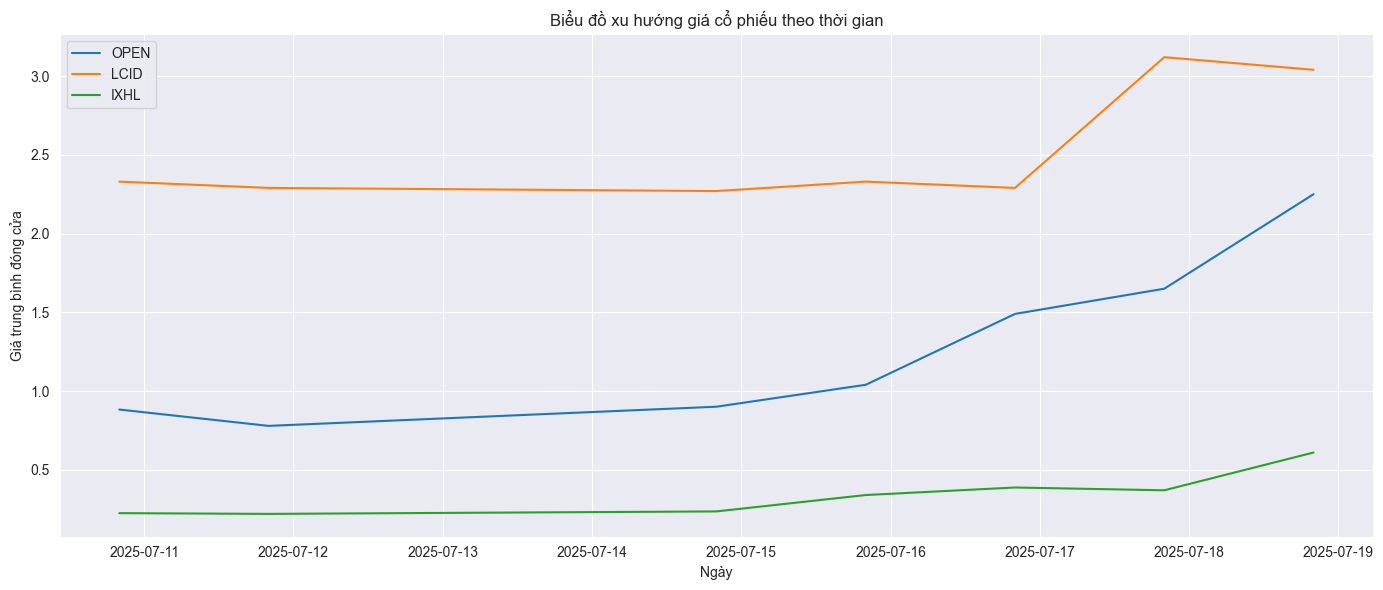

In [48]:
ticker = ["OPEN", "LCID", "IXHL"]  # Top 3 công ty có khối lượng giao dịch lớn nhất

# Lọc và xử lý dữ liệu
df_temp = df_joined.select("ticker", "time_stamp", "close") \
    .filter(F.col("ticker").isin(ticker)) \
    .groupBy("ticker", "time_stamp") \
    .agg(F.avg("close").alias("Giá trung bình")) \
    .orderBy("ticker", "time_stamp") \
    .withColumnRenamed("time_stamp", "Ngày giao dịch")

df_pd = df_temp.toPandas()

plt.figure(figsize=(14, 6))

# Lặp từng ticker để vẽ riêng
for t in ticker:
    df_ticker = df_pd[df_pd["ticker"] == t]
    plt.plot(df_ticker["Ngày giao dịch"], df_ticker["Giá trung bình"], label=t)

plt.xlabel("Ngày")
plt.ylabel("Giá trung bình đóng cửa")
plt.title("Biểu đồ xu hướng giá cổ phiếu theo thời gian")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**4. Quan sát và phân tích Dim News**

In [49]:
conn = duckdb.connect("../database/config_dwh/mydb.duckdb")

query = 'SELECT * FROM dim_news'
temp = conn.execute(query).fetchdf()

conn.close()

In [57]:
df_temp = pl.from_pandas(temp)
df_temp = df_temp.with_columns(
    pl.col("time_published").str.strptime(pl.Datetime, "%Y%m%dT%H%M%S"),
).drop(["authors","summary","url"])

In [58]:
df_news = spark.createDataFrame(df_temp.to_pandas())
df_news.printSchema()
df_news.show()

root
 |-- id: long (nullable = true)
 |-- title: string (nullable = true)
 |-- time_published: timestamp (nullable = true)
 |-- source: string (nullable = true)
 |-- overall_sentiment_score: double (nullable = true)
 |-- overall_sentiment_label: string (nullable = true)
 |-- time_id: long (nullable = true)

+---+--------------------+-------------------+----------------+-----------------------+-----------------------+-------+
| id|               title|     time_published|          source|overall_sentiment_score|overall_sentiment_label|time_id|
+---+--------------------+-------------------+----------------+-----------------------+-----------------------+-------+
|  1|Ligand Partner Pe...|2025-07-10 12:00:00|   GlobeNewswire|               0.273709|       Somewhat-Bullish|      1|
|  2|e-therapeutics De...|2025-07-10 12:00:00|   GlobeNewswire|               0.332621|       Somewhat-Bullish|      1|
|  3|Allegro MicroSyst...|2025-07-10 12:00:00|   GlobeNewswire|               0.309382|    

Số lượng bài báo từ các nguồn

In [59]:
df_news.groupBy("source") \
    .agg(F.count("*").alias("Số lượng bài báo")) \
    .orderBy(F.desc("Số lượng bài báo")) \
    .withColumnRenamed("source", "Nguồn") \
    .show()


+--------------------+----------------+
|               Nguồn|Số lượng bài báo|
+--------------------+----------------+
|    Zacks Commentary|            3190|
|            Benzinga|            2898|
|       GlobeNewswire|            1078|
|         Motley Fool|             578|
|       Cointelegraph|             232|
|          Decrypt.co|             132|
|                CNBC|              87|
|    Business Insider|              79|
|South China Morni...|              71|
|     Financial Times|              21|
|      Economic Times|              20|
|       The Economist|              11|
+--------------------+----------------+



Số lượng bài báo theo khung giờ

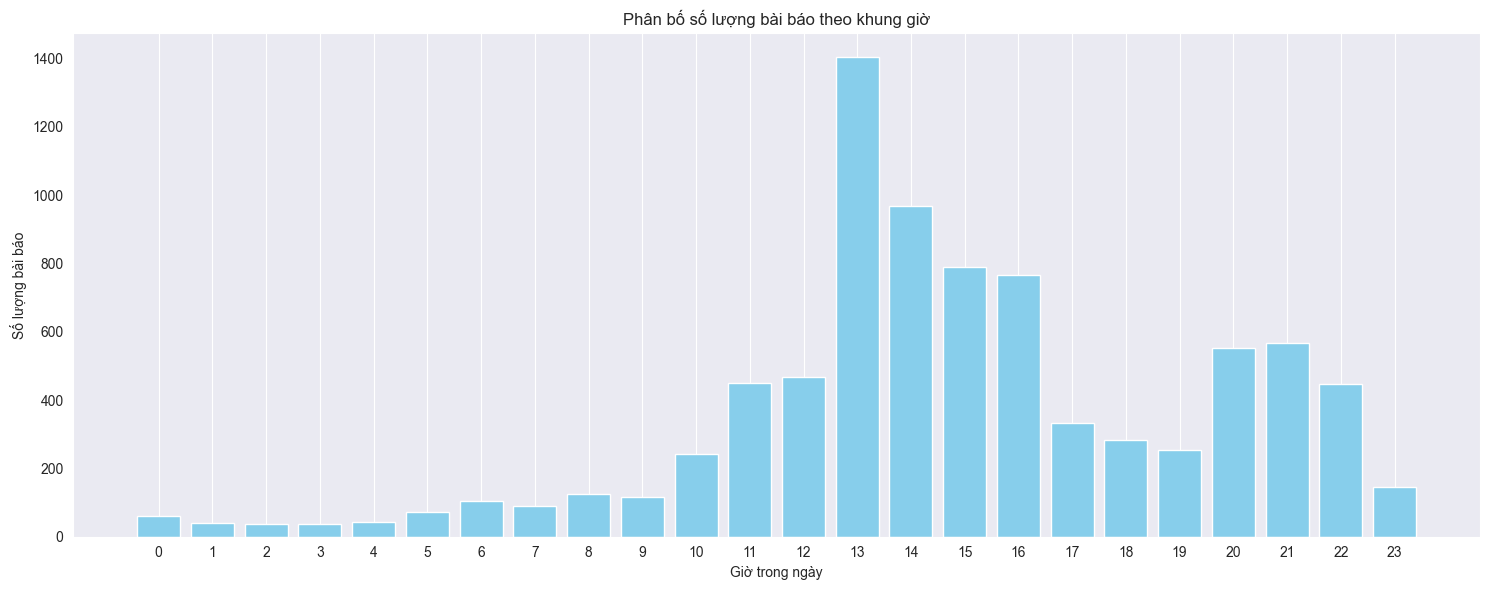

In [62]:
df_chart = df_news.withColumn("hour", F.hour(F.col("time_published"))) \
    .groupBy("hour") \
    .agg(F.count("*").alias("Số lượng bài báo")) \
    .orderBy(F.desc("Số lượng bài báo")) \
    .withColumnRenamed("hour", "Khung giờ")
df_pd = df_chart.toPandas()
plt.figure(figsize=(15,6))
plt.bar(df_pd["Khung giờ"], df_pd["Số lượng bài báo"], color="skyblue")
plt.xticks(range(0, 24))  # đảm bảo hiển thị đủ 0–23h
plt.xlabel("Giờ trong ngày")
plt.ylabel("Số lượng bài báo")
plt.title("Phân bố số lượng bài báo theo khung giờ")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

**5. Phân tích kết hợp đa bảng**

In [63]:
conn = duckdb.connect("../database/config_dwh/mydb.duckdb")

query = 'SELECT * FROM fact_news_companies'
temp = conn.execute(query).fetchdf()

conn.close()

In [64]:
df_news_companies = spark.createDataFrame(temp)
df_news_companies.printSchema()
df_news_companies.show()

root
 |-- id: long (nullable = true)
 |-- company_id: long (nullable = true)
 |-- new_id: long (nullable = true)
 |-- relevance_score: double (nullable = true)
 |-- ticker_sentiment_score: double (nullable = true)
 |-- ticker_sentiment_label: string (nullable = true)

+---+----------+------+---------------+----------------------+----------------------+
| id|company_id|new_id|relevance_score|ticker_sentiment_score|ticker_sentiment_label|
+---+----------+------+---------------+----------------------+----------------------+
|  1|      7728|     1|       0.061473|              0.158164|      Somewhat-Bullish|
|  2|     10737|     1|       0.122581|              0.029556|               Neutral|
|  3|     21199|     1|       0.061473|              0.158164|      Somewhat-Bullish|
|  4|     20079|     1|       0.061473|              0.158164|      Somewhat-Bullish|
|  5|      4631|     2|       0.059049|              0.184128|      Somewhat-Bullish|
|  6|     18006|     2|       0.059049|    

In [65]:
conn = duckdb.connect("../database/config_dwh/mydb.duckdb")

query = 'SELECT * FROM dim_time'
temp = conn.execute(query).fetchdf()

conn.close()

In [66]:
df_time = spark.createDataFrame(temp)
df_time.printSchema()
df_time.show()

root
 |-- id: long (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- month: string (nullable = true)
 |-- quarter: string (nullable = true)
 |-- year: long (nullable = true)

+---+-------------------+-----------+-----+-------+----+
| id|               date|day_of_week|month|quarter|year|
+---+-------------------+-----------+-----+-------+----+
|  1|2025-07-10 00:00:00|   Thursday| July|      3|2025|
|  2|2025-07-11 00:00:00|     Friday| July|      3|2025|
|  3|2025-07-14 00:00:00|     Monday| July|      3|2025|
|  4|2025-07-15 00:00:00|    Tuesday| July|      3|2025|
|  5|2025-07-16 00:00:00|  Wednesday| July|      3|2025|
|  6|2025-07-17 00:00:00|   Thursday| July|      3|2025|
|  7|2025-07-18 00:00:00|     Friday| July|      3|2025|
+---+-------------------+-----------+-----+-------+----+



Công ty được báo chí đề cập nhiều nhất

In [77]:
df_num_mentions = df_news_companies \
    .join(df_news, df_news_companies["new_id"] == df_news["id"]) \
    .join(df_companies, df_news_companies["company_id"] == df_companies["id"]) \
    .join(df_time, df_news["time_id"] == df_time["id"]) \
    .groupBy("ticker", "date") \
    .agg(F.count("*").alias("num_mentions")) \
    .orderBy("date", F.desc("num_mentions"))
df_num_mentions.show()


+------+-------------------+------------+
|ticker|               date|num_mentions|
+------+-------------------+------------+
|  GOOG|2025-07-10 00:00:00|          66|
|  NVDA|2025-07-10 00:00:00|          58|
|  META|2025-07-10 00:00:00|          55|
|  MSFT|2025-07-10 00:00:00|          40|
|  TSLA|2025-07-10 00:00:00|          29|
|  AAPL|2025-07-10 00:00:00|          25|
|    GS|2025-07-10 00:00:00|          20|
|  AMZN|2025-07-10 00:00:00|          20|
|  COIN|2025-07-10 00:00:00|          20|
|   DAL|2025-07-10 00:00:00|          18|
|   WFC|2025-07-10 00:00:00|          17|
|     C|2025-07-10 00:00:00|          17|
|  ENGS|2025-07-10 00:00:00|          14|
|   BAC|2025-07-10 00:00:00|          12|
|    MS|2025-07-10 00:00:00|          11|
|   BCS|2025-07-10 00:00:00|          11|
|   UAL|2025-07-10 00:00:00|          10|
|    MP|2025-07-10 00:00:00|          10|
|  PLTR|2025-07-10 00:00:00|          10|
|  FTRK|2025-07-10 00:00:00|           9|
+------+-------------------+------

Top 10 bài báo có sentiment thấp nhất (theo từng công ty)

In [78]:
df_top_negative_news = df_news_companies \
    .join(df_news, df_news_companies["new_id"] == df_news["id"]) \
    .join(df_companies, df_news_companies["company_id"] == df_companies["id"]) \
    .select("ticker", "title", "ticker_sentiment_score") \
    .orderBy("ticker_sentiment_score") \
    .limit(10)
df_top_negative_news.show()

+------+--------------------+----------------------+
|ticker|               title|ticker_sentiment_score|
+------+--------------------+----------------------+
|  MSFT|A Message to All ...|             -0.697516|
|  INTC|Should You Buy In...|             -0.624675|
|  UBER|Tesla Stock Is Fa...|             -0.585034|
|  SCAG|Frequency Electro...|             -0.573381|
|   PFE|A Message to All ...|             -0.565108|
|  SBUX|A Message to All ...|             -0.565108|
|  COST|A Message to All ...|             -0.565108|
|  NVDA|A Message to All ...|             -0.565108|
|    VZ|Yielding 6.3%, Is...|             -0.553461|
|   KHC|Company News for ...|             -0.546766|
+------+--------------------+----------------------+

